# Satellite Image Analysis: Pixel-Wise Classification

[RasterIO](https://rasterio.readthedocs.io/en/stable/) is used along with [EarthPy](https://earthpy.readthedocs.io/en/latest/index.html) to load an process the TIFF images separated in different bands.

Note that EarthPy has [example datasets](https://earthpy.readthedocs.io/en/latest/earthpy-data-subsets.html).

#### Table of Contents

1. Imports
2. Visualize Data
3. Preprocessing: Reshape, Scale, Split
4. Classification
    - 4.1 KNN
    - 4.2 Random Forest
    - 4.3 Visualize Failing Pixels

## 1. Imports 

In [97]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [2]:
DATA_PATH = "../data/Satellite_Imagery/"

In [98]:
sentinel_bands = glob(DATA_PATH+"sundarbans_data/*B?*.tiff")

In [5]:
sentinel_bands.sort()
sentinel_bands

['../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '../data/Satellite_Imagery/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '../data/

In [7]:
# Open rasters with Rasterio
images = []
for i in sentinel_bands:
    with rio.open(i, 'r') as f:
        images.append(f.read(1))

In [8]:
images_array = np.stack(images)

In [11]:
# 12 bands/channels with images of size (h,w) = (954, 298)
images_array.shape

(12, 954, 298)

In [12]:
type(images_array)

numpy.ndarray

## 2. Visualize Data

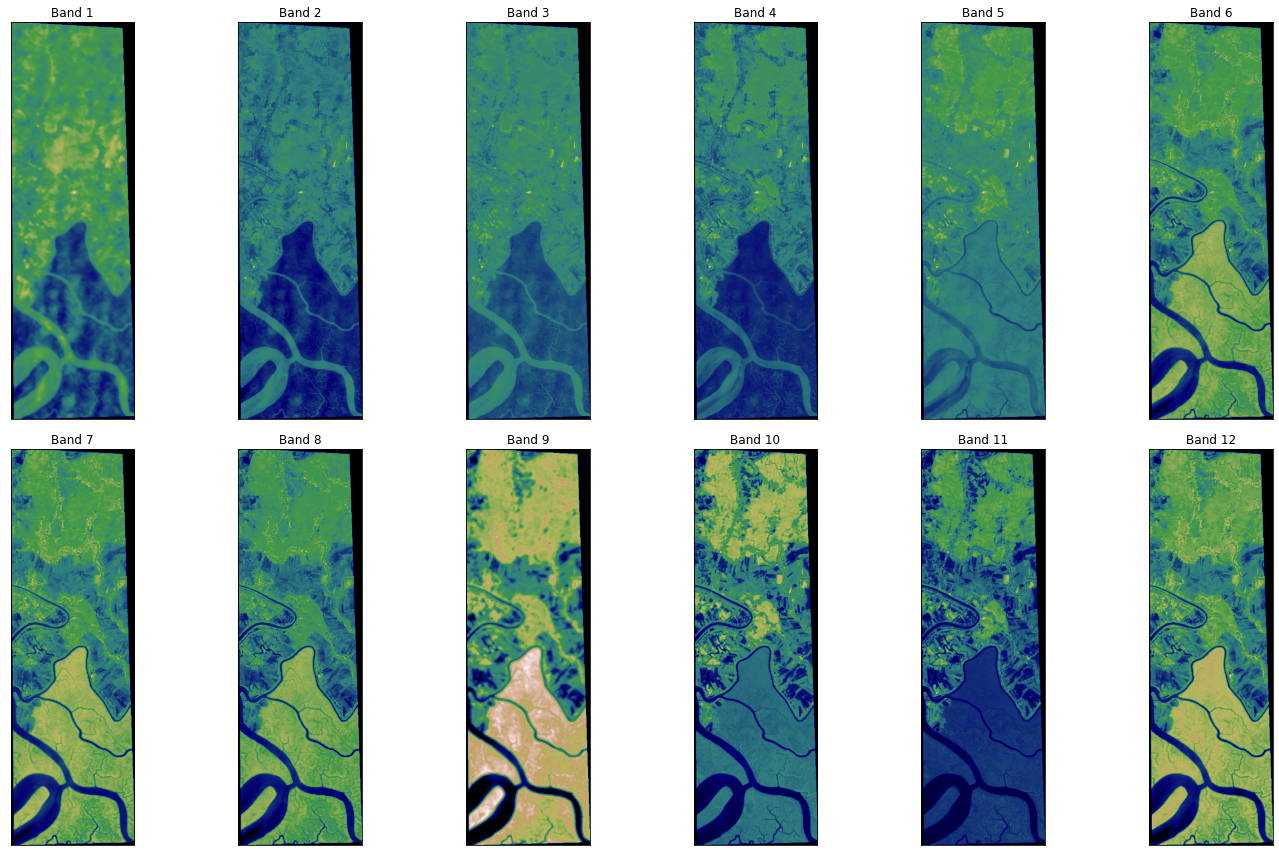

In [15]:
# Plot all bands
ep.plot_bands(images_array, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

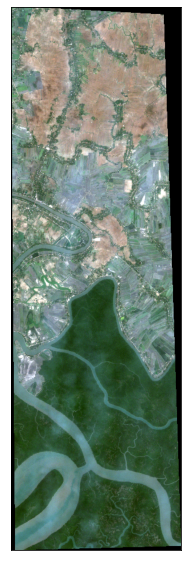

In [18]:
# Plot RGB image
rgb = ep.plot_rgb(images_array, 
                  rgb=(3,2,1), # (default = (0, 1, 2))) indices of the three RGB bands,
                  stretch=True, # apply linear stretch
                  str_clip=0.2, # pcnt of clip in linar stretch, default 2 = 2%
                  figsize=(8, 10))
plt.show()

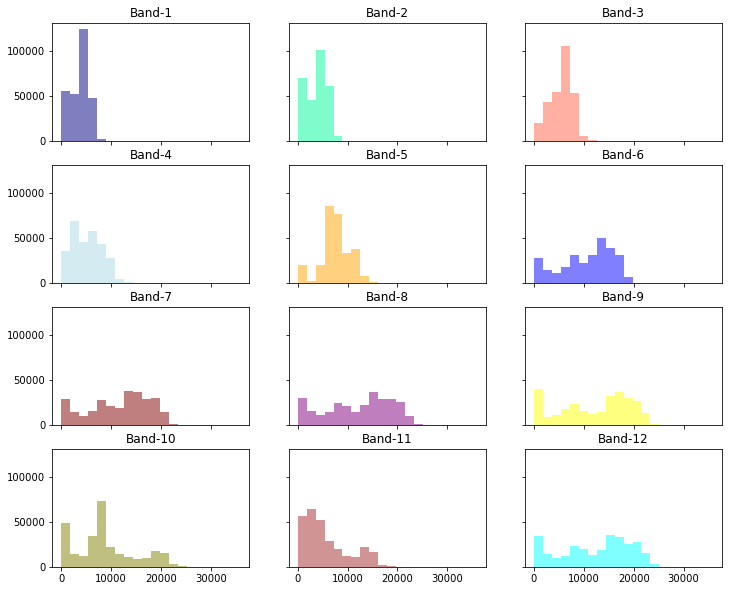

In [22]:
# Pixel value distributions: histograms
colors = ['navy', 'MediumSpringGreen', 'tomato', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']
ep.hist(images_array, 
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize=(12, 10))
plt.show()

## 3. Preprocessing: Reshape, Scale, Split

In [25]:
# Move channel/band dim to last position
X = np.moveaxis(images_array, 0, -1)
X.shape

(954, 298, 12)

In [26]:
X.min()

0

In [27]:
X.max()

35913

In [46]:
# Load targets: Matlab file
y = loadmat(DATA_PATH+"sundarbans_data/Sundarbands_gt.mat")['gt']

In [47]:
y.shape

(954, 298)

In [48]:
y.min()

0

In [49]:
y.max()

5

In [51]:
# We have 6 integer classes
# Each of the pixels belongs to one of these classes
np.unique(y)

array([0, 1, 2, 3, 4, 5], dtype=int32)

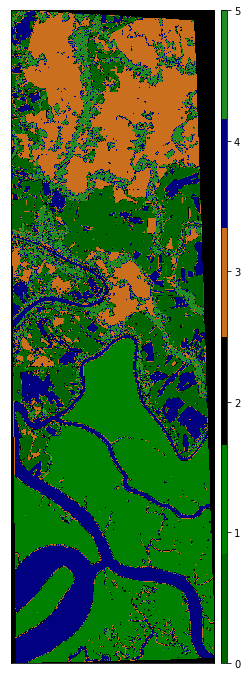

In [53]:
# Visualize froundtruth classes
ep.plot_bands(y,
              cmap=ListedColormap(['darkgreen',
                                   'green',
                                   'black',
                                   '#CA6F1E',
                                   'navy',
                                   'forestgreen']))
plt.show()

In [55]:
# Scale and reshape features/image pixel values
X = X.reshape(-1, 12)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_scaled.shape

(284292, 12)

In [58]:
# Reshape targets
y = y.reshape(-1) # also y.ravel()
y.shape

(284292,)

In [61]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y)

In [62]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(199004, 12)
(199004,)
(85288, 12)
(85288,)


## 4. Classification

Can the 12 band values in `X` be mapped to the `y` target value? Yes, they can.

### 4.1 KNN

In [67]:
#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(X_train, y_train)
#y_knn = knn.predict(X_test)

In [71]:
param_grid = {'n_neighbors':range(1, 16)}
grid_knn = GridSearchCV(KNeighborsClassifier(),
                        param_grid=param_grid,
                        scoring='f1_macro',
                        cv=3,
                        n_jobs=-1)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 16)}, scoring='f1_macro')

In [72]:
print(f"Best score: {grid_knn.best_score_}")
print(f"Best params: {grid_knn.best_params_}")

Best score: 0.9903771275252674
Best params: {'n_neighbors': 15}


In [73]:
y_knn = grid_knn.predict(X_test)

In [74]:
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16222
           1       1.00      1.00      1.00     23570
           2       1.00      1.00      1.00      6095
           3       0.99      0.99      0.99     16790
           4       0.99      0.99      0.99     13545
           5       0.98      0.97      0.97      9066

    accuracy                           0.99     85288
   macro avg       0.99      0.99      0.99     85288
weighted avg       0.99      0.99      0.99     85288



### 4.2 Random Forest

In [78]:
param_grid = {
  'max_depth': [15, 20],
  'n_estimators': [100, 200],
  'min_samples_split': [2, 5],
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=param_grid,
                       scoring='f1_macro',
                       cv=3,
                       n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_macro')

In [79]:
print(f"Best score: {grid_rf.best_score_}")
print(f"Best params: {grid_rf.best_params_}")

Best score: 0.9883500365398463
Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [80]:
y_rf = grid_rf.predict(X_test)

In [81]:
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16222
           1       1.00      1.00      1.00     23570
           2       1.00      1.00      1.00      6095
           3       0.99      0.99      0.99     16790
           4       0.99      0.99      0.99     13545
           5       0.97      0.97      0.97      9066

    accuracy                           0.99     85288
   macro avg       0.99      0.99      0.99     85288
weighted avg       0.99      0.99      0.99     85288



### 4.3 Visualize Failing Pixels

In this section, the pixels with a failed prediction are visualized.

In [82]:
y_pred = grid_knn.predict(X_scaled)

In [83]:
y_pred_img = y_pred.reshape((954, 298))

In [84]:
y_pred_img

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

In [87]:
y_img = y.reshape((954, 298))

In [88]:
y_img

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

In [89]:
y_diff = np.where(y_img == y_pred_img, 1, 0)

In [90]:
y_diff

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

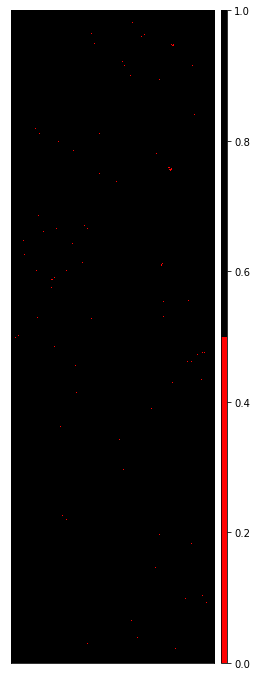

In [96]:
# Visualize froundtruth classes
ep.plot_bands(y_diff,
              cmap=ListedColormap(['red',
                                   'black']))
plt.show()